## Init

In [18]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio

import soundfile as sf
from IPython.display import Image, display, Audio


from pyannote.audio import Pipeline
from Multi_Decoder_DPRNN.model import MultiDecoderDPRNN
import whisper
from speechbrain.inference.speaker import SpeakerRecognition
from sklearn.metrics.pairwise import cosine_similarity


SADModel = Pipeline.from_pretrained("pyannote/voice-activity-detection")
OSDModel = Pipeline.from_pretrained("pyannote/overlapped-speech-detection")
DiarizationModel = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1") 
MD_model = MultiDecoderDPRNN(n_srcs=[2]) # hard part
whispermodel = whisper.load_model("medium")
SRModel = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/ecapa"
)

C:\Users\conno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\utilities\migration\migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\conno\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\059e96f964841d40f1a5e755bb7223f76666bba4\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.7.0+cpu. Bad things might happen unless you revert torch to 1.x.


Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\conno\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\059e96f964841d40f1a5e755bb7223f76666bba4\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.7.0+cpu. Bad things might happen unless you revert torch to 1.x.


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\conno\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b\pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
C:\Users\conno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\speechbrain\utils\fetching.py:151: UserWarning: Using SYMLINK strategy on Windows for fetching potentially requires elevated privileges and is not recommended. See `LocalStrategy` documentation.
  warnings.warn(
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.0+cpu. Bad things might happen unless you revert torch to 1.x.


C:\Users\conno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transf

### Helpers

#### Speech Activity Detection (SAD)

In [2]:
def has_speech(file_path):
    output = SADModel(file_path)
    # Check if there is at least one speech segment
    for segment in output.get_timeline().support():
        if segment.end > segment.start:
            return True
    return False



def SAD_plot(file_path):
    # Load audio to get duration
    audio, sr = sf.read(file_path)
    duration = len(audio) / sr

    # Create a time axis
    times = np.linspace(0, duration, len(audio))

    # Run SAD pipeline
    output = SADModel(file_path)

    # Create a binary mask (0 = no speech, 1 = speech)
    mask = np.zeros(len(audio), dtype=int)
    for speech in output.get_timeline().support():
        start_idx = int(speech.start * sr)
        end_idx = int(speech.end * sr)
        mask[start_idx:end_idx] = 1

    plt.figure(figsize=(12, 2))
    plt.plot(times, mask)
    plt.xlabel("Time (s)")
    plt.ylabel("Speech Activity")
    plt.title("Speech Activity Detection (1=speech, 0=no speech)")
    plt.ylim(-0.1, 1.1)
    display(Audio(file_path))
    plt.show()

# SAD_plot(file1)
# SAD_plot(file2)
# SAD_plot(file3)



def get_sad_mask(file_path):
    audio, sr = sf.read(file_path)
    output = SADModel(file_path)
    mask = np.zeros(len(audio), dtype=int)
    for speech in output.get_timeline().support():
        start_idx = int(speech.start * sr)
        end_idx = int(speech.end * sr)
        mask[start_idx:end_idx] = 1
    return mask, sr

# Get mask and sr for each file
# mask1, sr1 = get_sad_mask(file1)
# mask2, sr2 = get_sad_mask(file2)
# mask3, sr3 = get_sad_mask(file3)

def trim_audio_by_sad(file_path, mask):
    audio, sr = sf.read(file_path)
    if audio.ndim > 1 and mask.ndim == 1:
        audio = audio.mean(axis=1)
    speech_indices = np.where(mask == 1)[0]
    if len(speech_indices) == 0:
        print(f"No speech detected in {file_path}.")
        return None, sr
    start = speech_indices[0]
    end = speech_indices[-1] + 1
    trimmed_audio = audio[start:end]
    return trimmed_audio, sr

# # Trim audio
# trimmed_file1, sr1 = trim_audio_by_sad(file1, mask1)
# trimmed_file2, sr2 = trim_audio_by_sad(file2, mask2)
# trimmed_file3, sr3 = trim_audio_by_sad(file3, mask3)

# # Play trimmed audio (specify rate!)
# display(Audio(trimmed_file1, rate=sr1))
# display(Audio(trimmed_file2, rate=sr2))
# display(Audio(trimmed_file3, rate=sr3))

#### Overlapped Speech Detection (OSD)

In [3]:
def OSD_plot(file_path):
    # Load audio to get duration
    audio, sr = sf.read(file_path)
    # Ensure mono
    if audio.ndim > 1:
        audio = audio.mean(axis=1)
    duration = len(audio) / sr
    times = np.linspace(0, duration, len(audio))

    # Run OSD pipeline
    output = OSDModel(file_path)

    # Create a binary mask (1 = overlap, 0 = not overlap)
    mask = np.zeros(len(audio), dtype=int)
    for segment in output.get_timeline().support():
        start_idx = int(segment.start * sr)
        end_idx = int(segment.end * sr)
        mask[start_idx:end_idx] = 1

    plt.figure(figsize=(12, 2))
    plt.plot(times, mask)
    plt.xlabel("Time (s)")
    plt.ylabel("Overlapped Speech")
    plt.title("Overlapped Speech Detection (1=overlap, 0=single speaker)")
    plt.ylim(-0.1, 1.1)
    display(Audio(file_path))
    plt.show()

#### Diarization

In [4]:
def split_audio_by_diarization(audio_path, output_dir, verbose=False):

    diarization_result = DiarizationModel(audio_path)

    import soundfile as sf
    audio, sr = sf.read(audio_path)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)  # Ensure mono

    os.makedirs(output_dir, exist_ok=True)
    segment_paths = []

    for idx, segment in enumerate(diarization_result.itertracks(yield_label=False)):
        start = int(segment[0].start * sr)
        end = int(segment[0].end * sr)
        segment_audio = audio[start:end]
        out_path = os.path.join(output_dir, f"segment_{idx}.wav")
        sf.write(out_path, segment_audio, sr)
        segment_paths.append(out_path)
        if verbose: print(f"Saved: {out_path} ({segment[0].start:.2f}s - {segment[0].end:.2f}s)")

    return segment_paths

def seperate_speakers(file):
    diarization_result = DiarizationModel(file)
    output_dir = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments"
    segment_paths = split_audio_by_diarization(file, output_dir, verbose=True)

#### Transcription

In [5]:
def transcribe_speakers(output_dir, verbose=False):
    segment_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.wav')]
    for file_path in segment_files:
        try:
            result = whispermodel.transcribe(file_path, fp16=False)
            if verbose: display(Audio(file_path))
            print(result["text"])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue


## The Pipeline

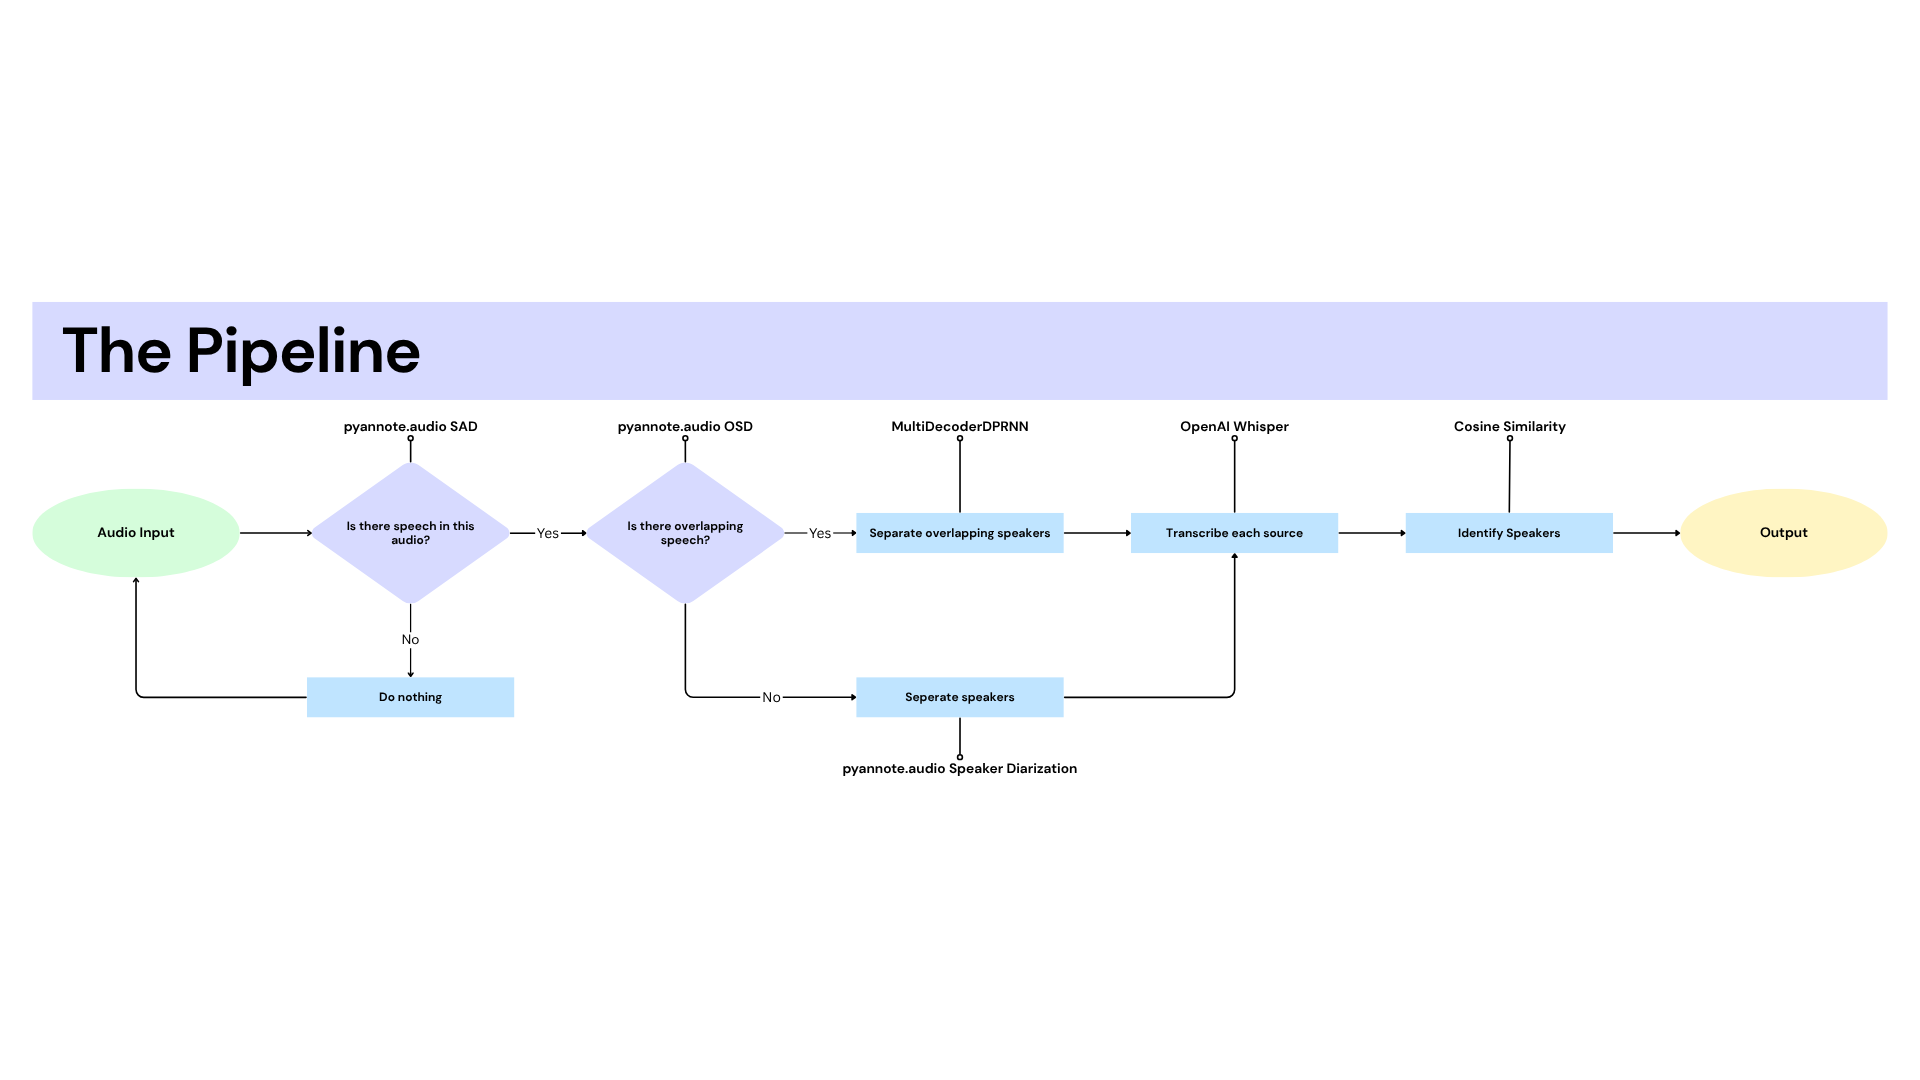

In [6]:
display(Image(filename=r"C:\Users\conno\Desktop\UoB_Project\cxb1114\thesis\figs\FlowChart.png"))

#### Testing Files

In [ ]:
file1 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\data\libricss\0S\overlap_ratio_0.0_sil0.1_0.5_session0_actual0.0\record\segments\segment_0.wav"
file2 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\data\libricss\0S\overlap_ratio_0.0_sil0.1_0.5_session0_actual0.0\record\segments\segment_1.wav"
file3 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\data\libricss\0S\overlap_ratio_0.0_sil0.1_0.5_session0_actual0.0\record\segments\segment_2.wav"

#### Model Pipeline

For now assuming no overlapping speech

In [8]:
def test_pipeline(file, temp_path):
    if has_speech(file):
        
        #Check for overlapping speech
        # if has_overlap(file1): seperate_overlap(file1)
        # else:
        seperate_speakers(file)

        transcribe_speakers(temp_path)
    else: return print(f"No speech detected in {file}. Skipping processing.")


In [9]:
display(Audio(realfile1))
test_pipeline(file=realfile1, temp_path=r"C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments")

Saved: C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_0.wav (2.07s - 4.44s)
Saved: C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_1.wav (5.01s - 7.98s)
Saved: C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_2.wav (7.98s - 11.34s)
Saved: C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_3.wav (11.98s - 13.29s)
Saved: C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_4.wav (14.24s - 17.07s)
 Where would you like to take the dog letter?
 I was thinking we could take him to Sutton Park.
 but it's quite far drive so if they're anywhere close by.
 We could just walk to the pub.
 Yeah, there's the golf course as well we could take him around before.


"Where would you like to take the dog **later**?"

"but it's quite a far drive so **is there** anywhere closer by"

In [ ]:
realfile1 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\data\real\ConnorTamsin_DogWalk.wav"

Connor_Learn = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\data\real\Connor_Learn.wav"
Tamsin_Learn = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\data\real\Tamsin_Learn.wav"

Connor1 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_0.wav"
Tamsin1 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_1.wav"
Tamsin2 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_2.wav"
Connor2 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_3.wav"
Tamsin3 = r"C:\Users\conno\Desktop\UoB_Project\cxb1114\notebooks\temp\diar_segments\segment_4.wav"

In [ ]:
def learn_voice(file, chunk_duration=5.0, target_sr=16000):
    """
    Splits the input audio file into 5-second chunks, computes embeddings for each chunk,
    and returns the average embedding vector.
    """

    # Load audio
    signal, sr = torchaudio.load(file)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        signal = resampler(signal)
        sr = target_sr

    # Ensure mono
    if signal.shape[0] > 1:
        signal = signal.mean(dim=0, keepdim=True)

    total_samples = signal.shape[1]
    chunk_samples = int(chunk_duration * sr)
    embeddings = []

    # Split into chunks and compute embeddings
    for start in range(0, total_samples, chunk_samples):
        end = min(start + chunk_samples, total_samples)
        chunk = signal[:, start:end]
        if chunk.shape[1] < int(0.5 * chunk_samples):  # Skip very short chunks (<2.5s)
            continue
        with torch.no_grad():
            emb = SRModel.encode_batch(chunk).squeeze().cpu().numpy()
        embeddings.append(emb)

    if len(embeddings) == 0:
        raise ValueError("No valid chunks found for embedding.")

    avg_embedding = np.mean(embeddings, axis=0)
    return avg_embedding

In [31]:
# Step 1: Enroll known speaker
connor_embedding = learn_voice(Connor_Learn)

# Step 2: Get embedding for test clip
audio, sr = sf.read(Connor1)
audio_len = len(audio) / sr
test_embedding = learn_voice(Connor1, chunk_duration=audio_len)

# Step 3: Compare embeddings
similarity = cosine_similarity([connor_embedding], [test_embedding])[0][0]
print(f"Cosine similarity: {similarity:.3f}")

# Step 4: Decide if it's Connor (choose a threshold, e.g., 0.7 or 0.8)
if similarity > 0.75:
    print("This is likely Connor.")
else:
    print("This is NOT Connor.")

Cosine similarity: 0.598
This is NOT Connor.


In [32]:
# Step 1: Enroll known speaker
tamsin_embedding = learn_voice(Tamsin_Learn)

# Step 2: Get embedding for test clip
audio, sr = sf.read(Tamsin2)
audio_len = len(audio) / sr
test_embedding = learn_voice(Tamsin2, chunk_duration=audio_len)

# Step 3: Compare embeddings
similarity_tamsin = cosine_similarity([tamsin_embedding], [test_embedding])[0][0]
print(f"Cosine similarity: {similarity_tamsin:.3f}")

# Step 4: Decide if it's Tamsin (choose a threshold, e.g., 0.7 or 0.8)
if similarity_tamsin > 0.75:
    print("This is likely Tamsin.")
else:
    print("This is NOT Tamsin.")

Cosine similarity: 0.496
This is NOT Tamsin.
